Next step:

Fix RNN

Test dense networks

ResNet?



### Utility / Load data
When you are running this notebook on colab - run the first 2 cells (remenber to change the path in cell 2) to mount your data to the right path, so that the notebook could locate it. 

If you are running this notebook on your local PC, there is no need to run the first 2 cells.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/gdrive/MyDrive/EE247/')
%cd gdrive/MyDrive/EE247

/content/gdrive/MyDrive/EE247


In [3]:
import numpy as np

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [4]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Visualization

In [5]:
import matplotlib.pyplot as plt

769


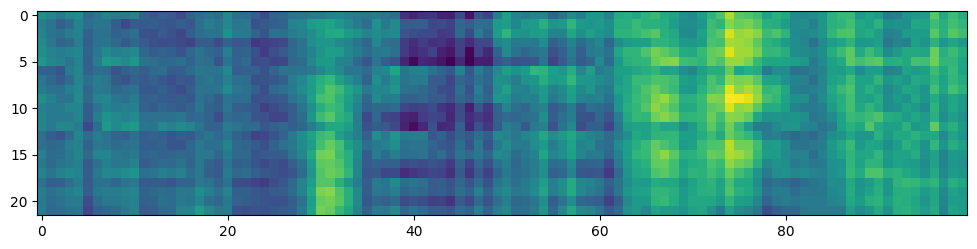

In [6]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
# for i in range(2115):

i=3
plt.imshow(X_train_valid[i, :, :100])
print(y_train_valid[i])

### Model

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import torch.nn.functional as F

### Check if CUDA is avaliable

In [8]:
use_cuda = torch.cuda.is_available()
use_cuda

True

### Model

Options:

"conv": fixed, so that the shape/dimensions match our dataset

"deepconv": fixed

"best": fixed (this means the best CNN model till now; probably also the best model overall)

"reg" and "base": fixed, BUT I haven't tested them out

other models: not fixed

In [19]:
class Net(nn.Module):

    def __init__(self, params):
        """
        We define a network based on the parameter to predict whether the slice is a seizure. The current models are:
        - base: flatten the matrix and apply a neural net with one hidden layer
        - conv: apply a standard vision neural net of 3 convolutional layers (filters, batch norm, pool, relu)
                and then flatten and apply two fully connected layers with batch norm and dropout
        - lstm: a

        Args:
            params: (Params) contains num_channels
        """
        super(Net, self).__init__()
        self.type = params["type"]

        if self.type == "reg":
            self.fc = nn.Linear(22 * 1000, 4)

        if self.type == "conv":
            self.num_channels = params["num_channels"]
            # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
            # stride, padding). We also include batch normalization layers that help stabilise training.
            self.conv1 = nn.Conv2d(1, self.num_channels, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(self.num_channels)
            self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(self.num_channels*2)
            self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
            self.bn3 = nn.BatchNorm2d(self.num_channels*4)

            # 2 fully connected layers to transform the output of the convolution layers to the final output
            self.fc1 = nn.Linear(125*2*self.num_channels*4, self.num_channels*4)
            self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
            self.fc2 = nn.Linear(self.num_channels*4, 4)
            self.dropout_rate = params["dropout_rate"]
        
        elif self.type == "base":
            # simple base model
            self.fc_1 = nn.Linear(22 * 1000, 1000)
            self.fc_2 = nn.Linear(1000, 30)
            self.fc_3 = nn.Linear(30, 4)

        elif self.type == "lstm":
            # input_size, hidden_size, num_layers
            self.lstm = nn.LSTM(22, 20, 2)
            # the fully connected layer transforms the output to give the final output layer
            self.fc = nn.Linear(20, 1)
            if params.bidirectional == 1:
                self.lstm = nn.LSTM(25, 20, 2, bidirectional=True)
                self.fc = nn.Linear(40, 4)

        if self.type == "deepconv":
            # in_channels, out_channels, kernel_size
            self.conv1 = nn.Conv2d(1, 25, (1,10), stride=1, padding=(0, 1))
            self.conv2 = nn.Conv2d(25, 50, (1,10), stride=1, padding=(0, 1))
            self.conv3 = nn.Conv2d(50, 100, (1,10), stride=1, padding=(0, 1))
            self.conv4 = nn.Conv2d(100, 200, (1,10), stride=1, padding=(0, 1))
            self.fc1 = nn.Linear(200*8*22, 400)
            self.fcbn1 = nn.BatchNorm1d(400)
            self.fc2 = nn.Linear(400, 4)
            self.dropout_rate = params["dropout_rate"]

        if self.type == "deepconv_nodo":
            # in_channels, out_channels, kernel_size
            self.conv1 = nn.Conv2d(1, 25, (1,10), stride=1, padding=(0, 1))
            self.conv2 = nn.Conv2d(25, 50, (1,10), stride=1, padding=(0, 1))
            self.conv3 = nn.Conv2d(50, 100, (1,10), stride=1, padding=(0, 1))
            self.conv4 = nn.Conv2d(100, 200, (1,10), stride=1, padding=(0, 1))
            self.fc1 = nn.Linear(200*8*22, 400)
            self.fcbn1 = nn.BatchNorm1d(400)
            self.fc2 = nn.Linear(400, 4)

        if self.type == "deeplstm":
            self.lstm = nn.LSTM(25, 20, 2, bidirectional=True)
            self.fc1 = nn.Linear(40, 10)
            self.fcbn1 = nn.BatchNorm1d(10)
            self.fc2 = nn.Linear(10, 1)

        if self.type == "best":
            self.conv1 = nn.Conv1d(1, 1, [1, 10]) 
            self.conv2 = nn.Conv1d(1, 1, [1, 10]) 
            self.conv3 = nn.Conv1d(1, 1, [1, 10]) 
            self.fc2 = nn.Linear(32*22, 4)
            self.m1 = nn.BatchNorm2d(1)
            self.m2 = nn.BatchNorm2d(1)
            self.m3 = nn.BatchNorm2d(1)
            

    def forward(self, s):
        """
        This function defines how we use the components of our network to operate on an input batch.
        Args:
            s: (Variable) contains a batch of images, of dimension batch_size x 2000 x 5.

        Returns:
            out: (Variable) dimension batch_size indicating probability of a seizure.

        Note: the dimensions after each step are provided
        """
        if (self.type == "reg"):
            s = s.view(-1, 22 * 1000)
            s = self.fc(s)
            return s

        if (self.type == "conv"):
            # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
            s = s.unsqueeze(1)                             # -> batch_size x 1 x 22 x 1000
            s = self.bn1(self.conv1(s))                    # batch_size x num_channels x 22 x 1000
            s = F.relu(F.max_pool2d(s, 2))                 # batch_size x num_channels x 11 x 500
            s = self.bn2(self.conv2(s))                    # batch_size x num_channels*2 x 11 x 500 
            s = F.relu(F.max_pool2d(s, 2))                 # batch_size x num_channels*2 x 5 x 250 
            s = self.bn3(self.conv3(s))                    # batch_size x num_channels*4 x 250 x 5
            s = F.relu(F.max_pool2d(s, 2))                 # batch_size x num_channels*4 x 125 x 2

            # flatten the output for each image
            s = s.view(-1, 125*2*self.num_channels*4)           # batch_size x 125*2*num_channels*4
            # apply 2 fully connected layers with dropout
            s = F.dropout(F.relu(self.fcbn1(self.fc1(s))),
                p=self.dropout_rate, training=self.training)    # batch_size x self.num_channels*4
            s = self.fc2(s)                                     # batch_size x 4
            return s

        elif (self.type == "base"):
            s = s.view(-1, 22 * 1000)
            s = F.relu(self.fc_1(s))
            s = F.relu(self.fc_2(s))
            s = self.fc_3(s)
            return s

        elif (self.type == "lstm"):
            s = s.transpose(0, 1)
            # Forward propagate RNN
            out, _ = self.lstm(s)  
            # Decode hidden state of last time step (seq_len, batch, hidden_size * num_directions)
            last_out = out[-1,:,:]
            out = self.fc(last_out)  
            return F.sigmoid(out)

        elif (self.type == "deeplstm"):
            s = s.transpose(0, 1)
            # Forward propagate RNN
            out, hidden = self.lstm(s)  
            # Decode hidden state of last time step (seq_len, batch, hidden_size * num_directions)
            s = F.relu(F.max_pool1d(hidden[0], 2))
            s = s.transpose(0, 1)
            s = s.contiguous()
            s = s.view(-1, 4 * 10)
            s = F.relu(self.fcbn1(self.fc1(s)))
            s = self.fc2(s)  
            return F.sigmoid(s)

        elif (self.type == "deepconv"):
            s = s.unsqueeze(1)                                   # -> batch_size x 1 x 22 x 1000
            s = F.elu(self.conv1(s))                             # batch_size x 25 x 22 x 1000
            s = F.max_pool2d(s, (1, 3))                          # batch_size x 25 x 22 x 331
            s = F.elu(self.conv2(s))                             # batch_size x 50 x 22 x 331 
            s = F.max_pool2d(s, (1, 3))                          # batch_size x 50 x 22 x 108 
            s = F.elu(self.conv3(s))                             # batch_size x 100 x 22 x 108
            s = F.max_pool2d(s, (1, 3))                          # batch_size x 100 x 22 x 33
            s = F.elu(self.conv4(s))                             # batch_size x 200 x 22 x 33 
            s = F.max_pool2d(s, (1, 3))                          # batch_size x 200 x 22 x 8 
            s = s.contiguous()
#             print(s.shape)
            s = s.view(-1, 200*8*22)
            s = F.dropout(F.relu(self.fcbn1(self.fc1(s))),p=self.dropout_rate, training=self.training)
            s = self.fc2(s)
            return s

        elif (self.type == "deepconv_nodo"):
            s = s.unsqueeze(1)
            s = F.relu(self.conv1(s))
            s = F.max_pool2d(s, (1, 3))
            s = F.relu(self.conv2(s))
            s = F.max_pool2d(s, (1, 3))
            s = F.relu(self.conv3(s))
            s = F.max_pool2d(s, (1, 3))
            s = F.relu(self.conv4(s))
            s = F.max_pool2d(s, (1, 3))
            s = s.contiguous()
            s = s.view(-1, 200*8*22)
            s = F.relu(self.fcbn1(self.fc1(s)))
            s = self.fc2(s)
            return s

        elif self.type == "best":
            s = s.unsqueeze(1)
            s = F.max_pool2d(F.elu(self.conv1(self.m1(s))), (1, 3)) # 1000 => 991 => 330
            s = F.max_pool2d(F.elu(self.conv2(self.m2(s))), (1, 3)) # 330 => 321 => 107
            s = F.max_pool2d(F.elu(self.conv3(self.m3(s))), (1, 3)) # 107 => 98 => 32
            s = s.view(-1, 32 * 22)
            s = self.fc2(s)
            return s




# def f1score(outputs, labels):
#     """
#     Compute the f1 score, given the outputs and labels for all slices.

#     Args:
#         outputs: (np.ndarray) dimension batch_size - sigmoid output of the model
#         labels: (np.ndarray) dimension batch_size - each element is 0 (nonseizure) or 1 (seizure)

#     Returns: (float) f1 score in [0,1]
#     """
#     outputs_round = np.rint(outputs)
#     labels = labels.reshape(outputs_round.shape)
#     numerator = np.sum(np.logical_and(outputs_round == 1, outputs_round == labels))
#     precision_denom = max(outputs_round.sum(), 1e-8)
#     recall_denom = max(labels.sum(), 1e-8)
#     precision = 1.0 * numerator / precision_denom
#     recall = 1.0 * numerator / recall_denom
#     if (precision + recall == 0):
#         return 0
#     f1 = 2 * (precision * recall) / (precision + recall)
#     # import ipdb; ipdb.set_trace()
#     return f1


# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
# metrics = {
#     'accuracy': accuracy,
#     'f1': f1score,
# }

Definition of 2 methods: loss and accuracy

In [10]:
def loss_fn(outputs, labels):
    """
    Compute the cross entropy loss given outputs and labels.

    Args:
        outputs: (Variable) dimension batch_size - output of the model
        labels: (Variable) dimension batch_size, where each element is 0 or 1

    Returns:
        loss (Variable): cross entropy loss for all slices in the batch
    """
    loss = nn.CrossEntropyLoss()
    out = loss(outputs, labels)
    return out


def accuracy(outputs, labels):
    """
    Compute the accuracy, given the outputs and labels for all slices.

    Args:
        outputs: (Variable) dimension batch_size - sigmoid output of the model
        labels: (Variable) dimension batch_size - each element is 0 (nonseizure) or 1 (seizure)

    Returns: (float) accuracy in [0,1]
    """
    s = torch.exp(outputs)
    accuracy = (labels == s.max(dim=1)[1]).type(torch.FloatTensor).mean().item()
    return accuracy

In [11]:
# change data / label into tensor

x = torch.tensor(X_train_valid).float()
y = torch.tensor(y_train_valid - 769, dtype=torch.int64)

x_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test - 769, dtype=torch.int64)


# if you want onehot encode:

# y_onehot = torch.FloatTensor(2115, 4)
# y_onehot.zero_()
# y_onehot.scatter_(1, y.view(-1, 1), 1)

### Training process w/ Adam

In [27]:
# params = {"type": "conv", "num_channels": 32, "dropout_rate": 0.8}
# params = {"type": "deepconv", "dropout_rate": 0.5}
params = {"type": "best"}

if use_cuda:
  net = Net(params).cuda()
else:
  net = Net(params)

With deeper Conv network you should set learning rate ~ $10^{-5}$. With shallow network (like the "*best*" network), it could be higher like $10^{-4}$.

In [28]:
import torch.optim as optim


# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=1.5e-4)


n_epochs = 100
batch_size = 15 # Note that 2115 = 31 * 70
lam = 1e-2
print_every = 10

torch.cuda.empty_cache()

if use_cuda:
    x_test_tensor = x_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

for epoch in range(n_epochs):

    permutation = torch.randperm(x.size()[0])
    for i in range(0, x.size()[0], batch_size):
        
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y[indices]

        if use_cuda:
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()

        outputs = net.forward(batch_x)
        loss = loss_fn(outputs, batch_y)

        loss.backward()
        optimizer.step()
        
    if epoch % print_every == 0:
        print("epoch %d,  batch loss: %.4f" %(epoch, loss))

        output_test = net(x_test_tensor)
        acc = accuracy(output_test, y_test_tensor)
        print("  test acc: %.4f" %acc)

epoch 0,  batch loss: 1.3085
  test acc: 0.3115
epoch 10,  batch loss: 1.1277
  test acc: 0.4108
epoch 20,  batch loss: 1.1945
  test acc: 0.4515
epoch 30,  batch loss: 1.1657
  test acc: 0.5079
epoch 40,  batch loss: 1.1735
  test acc: 0.5102
epoch 50,  batch loss: 0.8154
  test acc: 0.5282
epoch 60,  batch loss: 0.5579
  test acc: 0.5260
epoch 70,  batch loss: 0.7379
  test acc: 0.5034
epoch 80,  batch loss: 0.7986
  test acc: 0.5485
epoch 90,  batch loss: 0.6794
  test acc: 0.5372


In [29]:
if use_cuda:
  x_test_tensor = x_test_tensor.cuda()
  y_test_tensor = y_test_tensor.cuda()

output_test = net(x_test_tensor)
acc = accuracy(output_test, y_test_tensor)
print("  test acc: %.4f" %acc)

  test acc: 0.5418


best testing acc should be ~54%